In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import OneClassSVM
from sklearn.decomposition import PCA

In [2]:
train_file = "train_usm.csv"
test_file = "test_usm.csv"

df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

In [3]:
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

In [4]:
non_numeric_cols = ['proto', 'state', 'service', 'Label']  
df = df.drop(columns=non_numeric_cols, errors='ignore')

df = df.fillna(df.median())

In [5]:
df = df.fillna(df.median())

## Isolation Forest

In [7]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(df)

# Plot anomaly scores
sns.histplot(df["anomaly_score"], bins=30)
plt.title("Anomaly Score Distribution (Isolation Forest)")
plt.show()

In [8]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(df)

# Map anomaly labels: -1 = anomaly, 1 = normal
df["is_anomaly"] = df["anomaly_score"].apply(lambda x: "Anomaly" if x == -1 else "Normal")

print(df["is_anomaly"].value_counts())

sns.countplot(x=df["is_anomaly"])
plt.title("Anomaly Detection using Isolation Forest")
plt.show()

is_anomaly
Normal     2286153
Anomaly     253890
Name: count, dtype: int64


In [9]:
2286038 / (2286038 + 254005)

0.8999997244141142

              precision    recall  f1-score   support

           0       0.90      0.93      0.91   2218760
           1       0.38      0.30      0.33    321283

    accuracy                           0.85   2540043
   macro avg       0.64      0.61      0.62   2540043
weighted avg       0.83      0.85      0.84   2540043

Confusion Matrix:
[[2060417  158343]
 [ 225624   95659]]


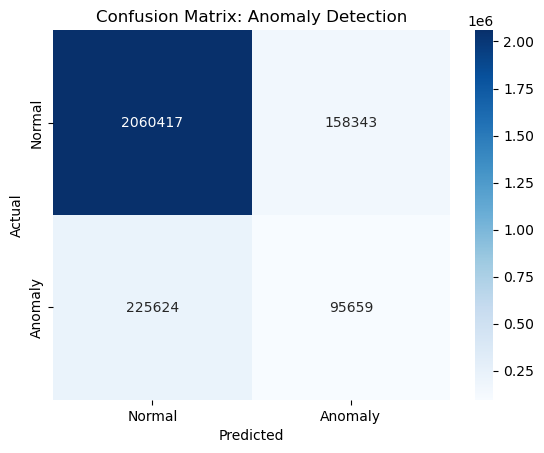

In [10]:
# Reload original dataset with 'Label' column
df_train = pd.read_csv(train_file)
df_test = pd.read_csv(test_file)

# Concatenate the train and test datasets for validation
df = pd.concat([df_train, df_test], axis=0, ignore_index=True)

# Drop non-numeric columns for anomaly detection (again)
non_numeric_cols = ['proto', 'state', 'service', 'Label']  
df_for_iso = df.drop(columns=non_numeric_cols, errors='ignore')

# Train Isolation Forest model
iso_forest = IsolationForest(n_estimators=100, contamination=0.1, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(df_for_iso)  

# Map anomaly labels: -1 = anomaly, 1 = normal
df["is_anomaly"] = df["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

# Now, validate using the 'Label' column
print(classification_report(df["Label"], df["is_anomaly"]))

# Confusion Matrix
conf_matrix = confusion_matrix(df["Label"], df["is_anomaly"])
print("Confusion Matrix:")
print(conf_matrix)

# Visualize confusion matrix for clarity
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Anomaly Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [11]:
58749/(58749 + 262534)

0.18285748078796574

### Interesting Insights:
1.  89% of the instances detected as normal by the model are actually normal.
2.  Precision for anomalies: This indicates that only 38% of the instances detected as anomalies by the model are actually true anomalies (attacks). This is a lower precision for anomalies, meaning many normal instances are being flagged as anomalous.
3.  False positives (normal data flagged as anomalies) are a significant issue, especially when the recall for anomalies is so low.

In [ ]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(df)

# Map anomaly labels: -1 = anomaly, 1 = normal
df["is_anomaly"] = df["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

print(classification_report(df["Label"], df["is_anomaly"]))

conf_matrix = confusion_matrix(df["Label"], df["is_anomaly"])
print("Confusion Matrix:")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Anomaly Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

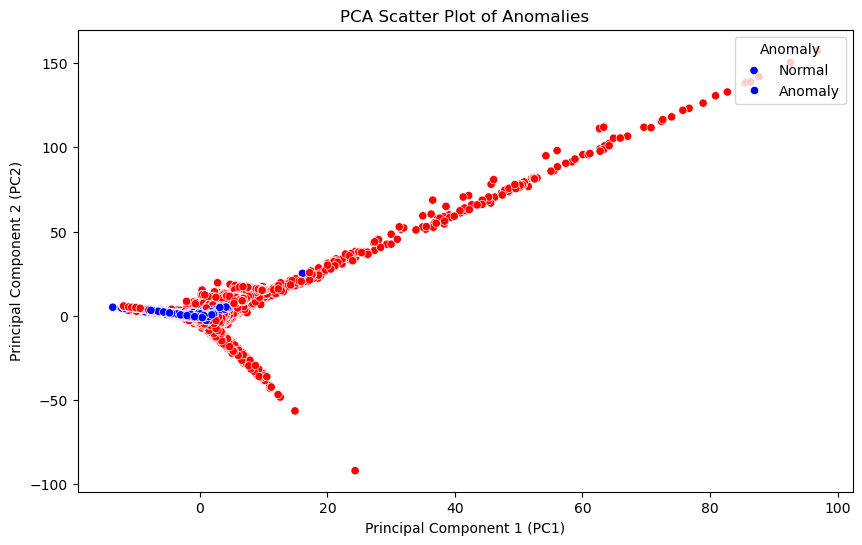

In [14]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)  # Use n_components=3 for 3D plot
df_pca = pca.fit_transform(df.drop(columns=["anomaly_score", "is_anomaly", "Label"]))  # Exclude non-feature columns

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])

# Add the anomaly labels back to the PCA DataFrame
df_pca["is_anomaly"] = df["is_anomaly"]

# Step 2: Plot the scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x="PC1", y="PC2", hue="is_anomaly", data=df_pca, palette={0: "blue", 1: "red"})
plt.title("PCA Scatter Plot of Anomalies")
plt.xlabel("Principal Component 1 (PC1)")
plt.ylabel("Principal Component 2 (PC2)")
plt.legend(title="Anomaly", loc="upper right", labels=["Normal", "Anomaly"])
plt.show()

### Hyperparameter Tuning 

In [16]:
iso_forest = IsolationForest(n_estimators=100, contamination=0.03, random_state=42)
df["anomaly_score"] = iso_forest.fit_predict(df)

# Map anomaly labels: -1 = anomaly, 1 = normal
df["is_anomaly"] = df["anomaly_score"].apply(lambda x: 1 if x == -1 else 0)

print(classification_report(df["Label"], df["is_anomaly"]))

conf_matrix = confusion_matrix(df["Label"], df["is_anomaly"])
print("Confusion Matrix:")
print(conf_matrix)

sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Anomaly"], yticklabels=["Normal", "Anomaly"])
plt.title("Confusion Matrix: Anomaly Detection")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

              precision    recall  f1-score   support

           0       0.88      0.98      0.93   2218760
           1       0.37      0.09      0.14    321283

    accuracy                           0.87   2540043
   macro avg       0.63      0.53      0.54   2540043
weighted avg       0.82      0.87      0.83   2540043

Confusion Matrix:
[[2171076   47684]
 [ 292765   28518]]


After hyperparameter tuning, contamination increase to 0.5. which significantly increases the recall from 92% to 96%. Which is helpful for the missed targets. 

In [18]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df)

plt.figure(figsize=(10, 8))
plt.scatter(df_pca[df["is_anomaly"] == 0, 0], df_pca[df["is_anomaly"] == 0, 1], 
            c='blue', label='Normal', alpha=0.6, s=40, edgecolors='w', linewidth=0.5)
plt.scatter(df_pca[df["is_anomaly"] == 1, 0], df_pca[df["is_anomaly"] == 1, 1], 
            c='red', label='Anomaly', alpha=0.8, s=40, edgecolors='w', linewidth=0.5)

plt.title("2D PCA Projection of Anomalies vs Normal Points", fontsize=16, fontweight='bold')
plt.xlabel("Principal Component 1", fontsize=14)
plt.ylabel("Principal Component 2", fontsize=14)

plt.legend(loc="upper right", fontsize=12)

plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.show()


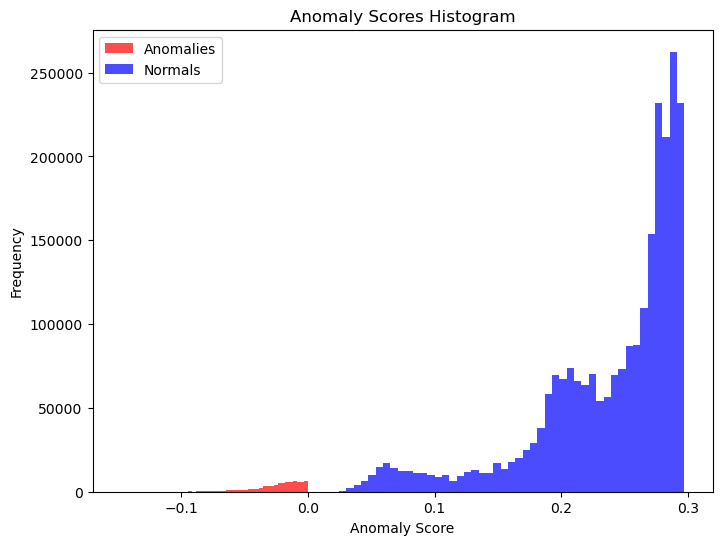

In [19]:
scores = iso_forest.decision_function(df)

plt.figure(figsize=(8, 6))
plt.hist(scores[df["is_anomaly"] == 1], bins=50, color='red', alpha=0.7, label='Anomalies')
plt.hist(scores[df["is_anomaly"] == 0], bins=50, color='blue', alpha=0.7, label='Normals')
plt.title("Anomaly Scores Histogram")
plt.xlabel("Anomaly Score")
plt.ylabel("Frequency")
plt.legend()
plt.show()


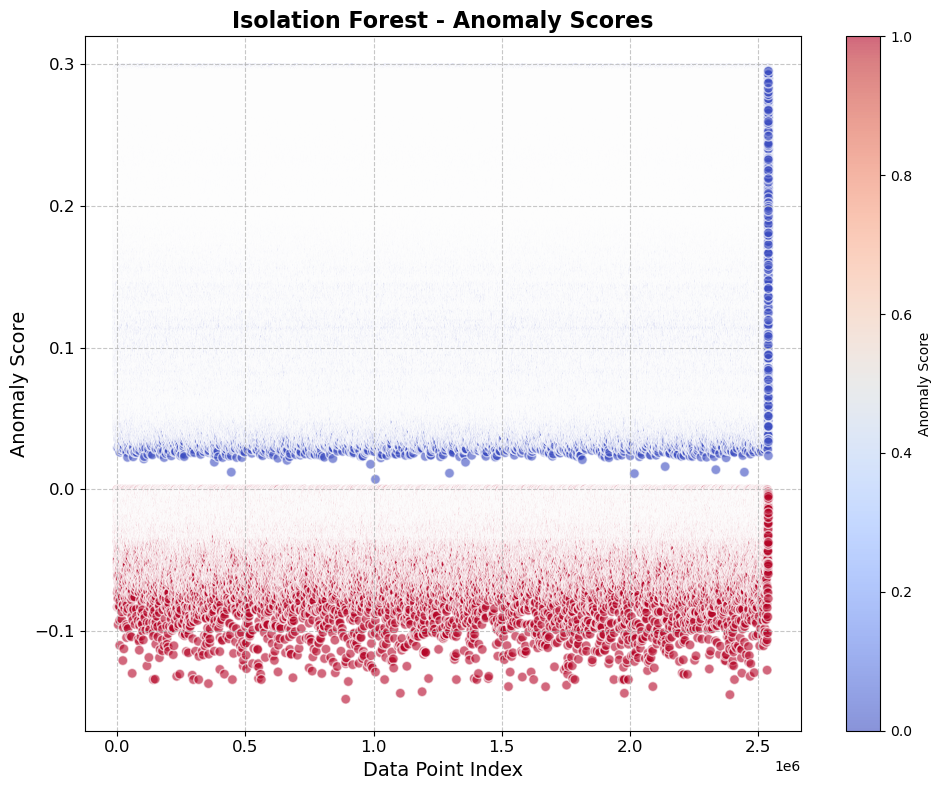

In [20]:
# Get the decision function scores for each point (anomaly scores)
scores = iso_forest.decision_function(df)

# Create a clean plot
plt.figure(figsize=(10, 8))
plt.scatter(range(len(scores)), scores, c=df["is_anomaly"], cmap='coolwarm', edgecolors='w', s=50, alpha=0.6)

# Title and labels
plt.title("Isolation Forest - Anomaly Scores", fontsize=16, fontweight='bold')
plt.xlabel("Data Point Index", fontsize=14)
plt.ylabel("Anomaly Score", fontsize=14)

# Customize grid and ticks
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Show the color bar and legend
plt.colorbar(label='Anomaly Score')
plt.tight_layout()
plt.show()


### Local Outlier Factor

In [40]:
from sklearn.neighbors import LocalOutlierFactor

# Define the LOF model (tune n_neighbors)
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)

# Predict anomalies (-1 = anomaly, 1 = normal)
y_pred_lof = lof.fit_predict(df_test)

# Convert LOF results (-1 → 1 for attack, 1 → 0 for normal)
df_test["anomaly"] = (y_pred_lof == -1).astype(int)

# Check results
print(df_test["anomaly"].value_counts())

anomaly
0    482608
1     25401
Name: count, dtype: int64


## Ensemble Learning 

In [41]:
# Fit Isolation Forest
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(n_estimators=100, contamination=0.05, random_state=42)
iso_preds = iso_forest.fit_predict(df_test)

# Fit LOF
lof = LocalOutlierFactor(n_neighbors=20, contamination=0.05)
lof_preds = lof.fit_predict(df_test)

# Convert (-1 → 1 for anomaly, 1 → 0 for normal)
iso_anomalies = (iso_preds == -1).astype(int)
lof_anomalies = (lof_preds == -1).astype(int)

# Combine (if either model detects an anomaly, classify as attack)
df_test["hybrid_anomaly"] = (iso_anomalies | lof_anomalies)

# Check results
print(df_test["hybrid_anomaly"].value_counts())


hybrid_anomaly
0    459017
1     48992
Name: count, dtype: int64


In [42]:
from sklearn.metrics import classification_report, confusion_matrix

# Compare hybrid model predictions with actual labels
print(classification_report(df_test["Label"], df_test["hybrid_anomaly"]))

# Confusion Matrix
cm = confusion_matrix(df_test["Label"], df_test["hybrid_anomaly"])
print("Confusion Matrix:\n", cm)


              precision    recall  f1-score   support

           0       0.89      0.92      0.90    443752
           1       0.26      0.20      0.23     64257

    accuracy                           0.83    508009
   macro avg       0.57      0.56      0.56    508009
weighted avg       0.81      0.83      0.82    508009

Confusion Matrix:
 [[407503  36249]
 [ 51514  12743]]


In [43]:
# Count actual attacks detected
actual_attacks = df_test[df_test["Label"] == 1]
detected_attacks = actual_attacks[actual_attacks["hybrid_anomaly"] == 1]

print(f"Total Actual Attacks: {len(actual_attacks)}")
print(f"Attacks Detected by Hybrid Model: {len(detected_attacks)}")
print(f"Detection Rate: {len(detected_attacks) / len(actual_attacks) * 100:.2f}%")


Total Actual Attacks: 64257
Attacks Detected by Hybrid Model: 12743
Detection Rate: 19.83%


### The better perfroming Model is the isolation forest with contamiantion of 0.3

### One Class SVM 

Classification Report:
              precision    recall  f1-score   support

           0       0.68      0.04      0.07    443752
           1       0.12      0.87      0.20     64257

    accuracy                           0.14    508009
   macro avg       0.40      0.46      0.14    508009
weighted avg       0.61      0.14      0.09    508009



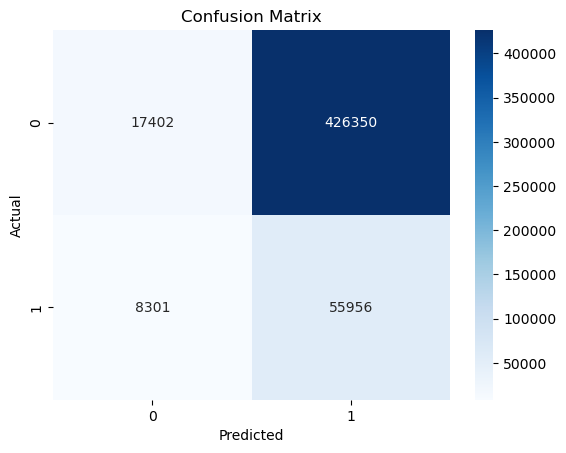

In [56]:
import pandas as pd
from sklearn.svm import OneClassSVM
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
train_svm = pd.read_csv('train_usm.csv')
test_svm = pd.read_csv('test_usm.csv')

# Subsample the training data (e.g., 100,000 rows)
train_svm_sampled = train_svm.sample(n=100000, random_state=42)  # Adjust n as needed

# Separate features and labels
X_train_svm = train_svm_sampled.drop(columns=['Label'])  # Features for training
y_train_svm = train_svm_sampled['Label']  # Labels for training (not used in One-Class SVM training)

X_test_svm = test_svm.drop(columns=['Label'])  # Features for testing
y_test_svm = test_svm['Label']  # Labels for testing (used for evaluation)

# Initialize and train the One-Class SVM model
oc_svm = OneClassSVM(kernel='rbf', nu=0.05)  # nu is the expected proportion of outliers
oc_svm.fit(X_train_svm)  # Train on the subsampled data

# Predict anomalies on the test data
y_pred = oc_svm.predict(X_test_svm)

# Convert predictions to binary labels (1 for normal, -1 for anomalies)
y_pred_binary = [1 if x == 1 else 0 for x in y_pred]

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test_svm, y_pred_binary))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_svm, y_pred_binary)  # Fixed: Removed extra parenthesis
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## K-Means

In [46]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

train = pd.read_csv('train_usm.csv')
test = pd.read_csv('test_usm.csv')

df_kmeans = train.drop(columns=['Label'])

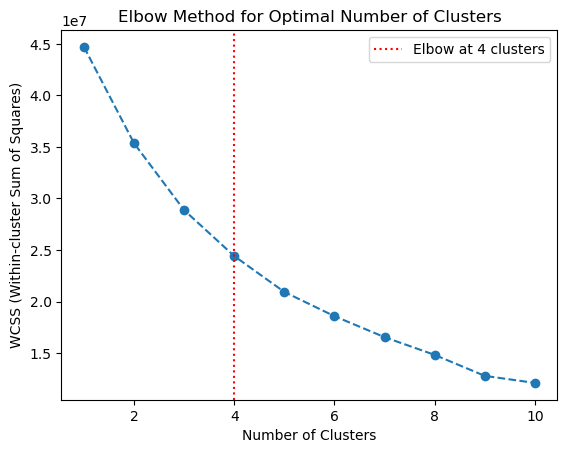

In [47]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=42)
    kmeans.fit(df_kmeans)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss, marker='o', linestyle='--')  # Add marker and dashed line
plt.title('Elbow Method for Optimal Number of Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-cluster Sum of Squares)')

# Optional: Add a vertical line at the elbow point (e.g., at cluster 3 or 4)
elbow_point = 4  # Change this to the cluster number where you think the elbow is
plt.axvline(x=elbow_point, color='red', linestyle=':', label=f'Elbow at {elbow_point} clusters')
plt.legend()

plt.show()

In [83]:
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(df_kmeans)

train['Cluster'] = y_kmeans

from sklearn.decomposition import PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(df_kmeans)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_pca[:, 0], y=X_pca[:, 1], hue=train['Cluster'], palette='viridis')
plt.title('K-Means Clustering of Cyber Attacks (2D PCA)')
plt.show()

print(train.groupby('Cluster').mean())


              dur    sbytes    dbytes      sttl      dttl     sloss     dloss  \
Cluster                                                                         
0       -0.013096 -0.009947 -0.141875 -0.310680 -0.079375  0.006041 -0.128140   
1       -0.043672 -0.077783 -0.225503  1.276164 -0.712547 -0.241280 -0.286943   
2        0.064170  0.104661 -0.181387  1.703960  5.016565  0.049591 -0.205044   
3        0.501575  0.549461  5.157691 -0.419487 -0.002136  1.045300  5.142365   

            Sload     Dload     Spkts  ...    tcprtt    synack    ackdat  \
Cluster                                ...                                 
0       -0.237211  0.134919 -0.067730  ... -0.123504 -0.111801 -0.116636   
1        1.330985 -0.577676 -0.415626  ... -0.133868 -0.126954 -0.120237   
2       -0.311041 -0.571116 -0.192776  ...  3.504315  3.197537  3.282347   
3       -0.310872  0.108519  4.198443  ... -0.100407 -0.090092 -0.095682   

         is_sm_ips_ports  ct_srv_src  ct_srv_dst  ct_dst

In [49]:
df_kmeans['Cluster'] = kmeans.labels_

In [50]:
df_kmeans['Cluster'].value_counts()

Cluster
0    1589010
1     313466
2      69692
3      59866
Name: count, dtype: int64

In [51]:
df_kmeans['Label'] = train['Label']  # Add Label column for comparison
attack_distribution = df_kmeans.groupby('Cluster')['Label'].value_counts(normalize=True)
print(attack_distribution)


Cluster  Label
0        0        0.965472
         1        0.034528
1        0        0.503094
         1        0.496906
2        1        0.659330
         0        0.340670
3        0        0.992533
         1        0.007467
Name: proportion, dtype: float64


In [52]:
df_kmeans['Anomaly'] = df_kmeans['Cluster'].apply(lambda x: 1 if x == 4 else 0)

### Key Takeaways:
#### Cluster 0 – Normal Traffic (Largest Group): Contains most of the data (1.58M records) → Likely benign network traffic with no major anomalies.
#### Cluster 1 – Suspicious Activity (Potential Probing & Scanning): Medium-sized (313K records) → Could represent scanning/probing activity, where attackers test networks for vulnerabilities.
#### Cluster 2 – Anomalous Traffic (Potential Malware/Botnet Activity): Smaller group (69K records) → Likely an indicator of unusual behavior, possibly due to malware infections or botnets.
#### Cluster 3 – High-Risk Attacks (Intrusions & Exploits): Smallest group (59K records) but potentially the most dangerous. May include denial-of-service (DoS), brute force attacks, or privilege escalation attempts.


In [54]:
import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Select a random sample if dataset is too large
df_sample = df_kmeans.sample(n=5000, random_state=42)  

# Select numeric columns (excluding categorical and cluster columns)
numeric_cols = df_sample.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols.remove('Cluster') 

# Apply PCA (optimized)
pca = PCA(n_components=3, svd_solver='auto') 
principal_components = pca.fit_transform(df_sample)

# Convert to DataFrame
df_pca = pd.DataFrame(principal_components, columns=['PC1', 'PC2', 'PC3'])
df_pca['Cluster'] = df_sample['Cluster']  

# Create interactive 3D plot
fig = px.scatter_3d(df_pca, 
                     x='PC1', 
                     y='PC2', 
                     z='PC3', 
                     color=df_pca['Cluster'].astype(str),
                     opacity=0.7,
                     title="Optimized 3D PCA Visualization of Cyber Attack Clusters",
                     labels={'color': 'Cluster'},
                     hover_data=df_pca.columns)

fig.update_traces(marker=dict(size=3, opacity=0.7, line=dict(width=0.5)))
fig.update_layout(template="plotly_dark", 
                  scene=dict(
                      xaxis_title='Principal Component 1', 
                      yaxis_title='Principal Component 2', 
                      zaxis_title='Principal Component 3'
                  ))

# Show plot
fig.show()


In [55]:
import pandas as pd
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D  # For 3D plotting

# Load data
train = pd.read_csv('train_usm.csv')
test = pd.read_csv('test_usm.csv')

# Prepare data for K-Means
df_kmeans = train.drop(columns=['Label'])

# Perform K-Means clustering
kmeans = KMeans(n_clusters=4, init='k-means++', max_iter=300, n_init=10, random_state=42)
y_kmeans = kmeans.fit_predict(df_kmeans)
train['Cluster'] = y_kmeans

# Reduce data to 3 principal components for 3D visualization
pca = PCA(n_components=3)
X_pca = pca.fit_transform(df_kmeans)

# Create a 3D plot
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot with color-coded clusters
scatter = ax.scatter(
    X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], 
    c=train['Cluster'], cmap='tab10', s=30, alpha=0.7, edgecolor='k'
)

# Plot cluster centers
centers = pca.transform(kmeans.cluster_centers_)
ax.scatter(
    centers[:, 0], centers[:, 1], centers[:, 2], 
    c='red', marker='X', s=200, label='Cluster Centers', depthshade=False
)

# Add labels and title
ax.set_xlabel('PCA Component 1', fontsize=12)
ax.set_ylabel('PCA Component 2', fontsize=12)
ax.set_zlabel('PCA Component 3', fontsize=12)
plt.title('3D K-Means Clustering of Cyber Attacks (PCA Reduced)', fontsize=16)

# Add a color bar to indicate clusters
cbar = plt.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Cluster', rotation=270, labelpad=15)

# Adjust viewing angle for better visibility
ax.view_init(elev=20, azim=45)  # Adjust elevation and azimuth angles

# Add gridlines and legend
ax.grid(True)
ax.legend()

# Adjust layout for better visibility
plt.tight_layout()
plt.show()

# Print cluster means
print(train.groupby('Cluster').mean())

/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py:493: UserWarning:

X does not have valid feature names, but PCA was fitted with feature names



              dur    sbytes    dbytes      sttl      dttl     sloss     dloss  \
Cluster                                                                         
0       -0.013096 -0.009947 -0.141875 -0.310680 -0.079375  0.006041 -0.128140   
1       -0.043672 -0.077783 -0.225503  1.276164 -0.712547 -0.241280 -0.286943   
2        0.064170  0.104661 -0.181387  1.703960  5.016565  0.049591 -0.205044   
3        0.501575  0.549461  5.157691 -0.419487 -0.002136  1.045300  5.142365   

            Sload     Dload     Spkts  ...    tcprtt    synack    ackdat  \
Cluster                                ...                                 
0       -0.237211  0.134919 -0.067730  ... -0.123504 -0.111801 -0.116636   
1        1.330985 -0.577676 -0.415626  ... -0.133868 -0.126954 -0.120237   
2       -0.311041 -0.571116 -0.192776  ...  3.504315  3.197537  3.282347   
3       -0.310872  0.108519  4.198443  ... -0.100407 -0.090092 -0.095682   

         is_sm_ips_ports  ct_srv_src  ct_srv_dst  ct_dst

### Gaussian Mixture Model for Clustering

In [58]:
import pandas as pd
from sklearn.mixture import GaussianMixture
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
train_svm = pd.read_csv('train_usm.csv')
test_svm = pd.read_csv('test_usm.csv')

# Separate features and labels
X_train_svm = train_svm.drop(columns=['Label'])  # Features for training
y_train_svm = train_svm['Label']  # Labels for training (not used in GMM)

X_test_svm = test_svm.drop(columns=['Label'])  # Features for testing
y_test_svm = test_svm['Label']  # Labels for testing (used for evaluation)

# Initialize and fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=3, random_state=42)  # Adjust n_components as needed
gmm.fit(X_train_svm)

# Compute log-likelihood for each sample in the test set
log_likelihood = gmm.score_samples(X_test_svm)

# Identify anomalies (points with low log-likelihood)
threshold = np.percentile(log_likelihood, 5)  # Set threshold as the 5th percentile
y_pred = log_likelihood < threshold  # True for anomalies, False for normal
y_pred_binary = y_pred.astype(int)  # Convert to binary labels (1 for anomalies, 0 for normal)

# Evaluate the model (if you have labeled data)
print("Classification Report:")
print(classification_report(y_test_svm, y_pred_binary))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test_svm, y_pred_binary)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.95      0.91    443752
           1       0.20      0.08      0.11     64257

    accuracy                           0.84    508009
   macro avg       0.54      0.52      0.51    508009
weighted avg       0.79      0.84      0.81    508009



In [59]:
from sklearn.decomposition import PCA

# Reduce test data to 2D for visualization
pca = PCA(n_components=2)
X_test_pca = pca.fit_transform(X_test_svm)

# Plot the results
plt.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=y_pred, cmap='viridis')
plt.colorbar(label='Anomaly (1) / Normal (0)')
plt.title('GMM Anomaly Detection')
plt.show()

In [73]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame and it has already been loaded

# Step 1: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)  # Use n_components=3 for 3D plot
df_pca = pca.fit_transform(df.drop(columns=["anomaly_score", "is_anomaly", "Label"]))  # Exclude non-feature columns

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])

# Add the anomaly labels back to the PCA DataFrame
df_pca["is_anomaly"] = df["is_anomaly"]

# Step 2: Plot the scatter plot with black background and pink/green dots
plt.style.use('dark_background')  # Set the background to black
plt.figure(figsize=(10, 6))

# Create the scatter plot
scatter = sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="is_anomaly", 
    data=df_pca, 
    palette={0: "magenta", 1: "lightgreen"},  # Pink for normal, green for anomalies
    edgecolor="none"  # Remove edge color for cleaner dots
)

# Customize the legend
legend = plt.legend(
    title="Anomaly", 
    loc="upper right", 
    labels=["Normal", "Anomaly"], 
    title_fontsize="13", 
    fontsize="12", 
    facecolor="black", 
    edgecolor="white"
)

# Set title and axis labels with white color
plt.title("PCA Scatter Plot of Anomalies", color="white")
plt.xlabel("Principal Component 1 (PC1)", color="white")
plt.ylabel("Principal Component 2 (PC2)", color="white")

plt.show()

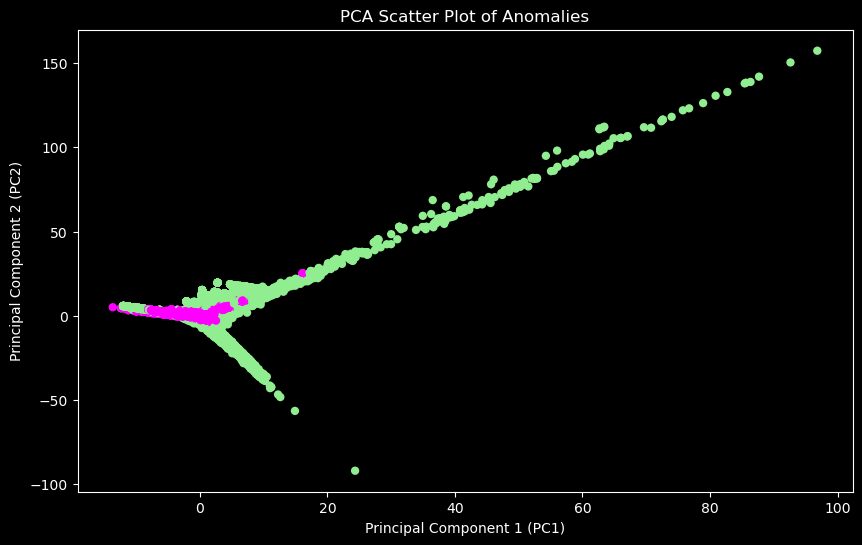

In [86]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Assuming df is your DataFrame and it has already been loaded

# Step 1: Apply PCA to reduce the data to 2 dimensions
pca = PCA(n_components=2)  # Use n_components=3 for 3D plot
df_pca = pca.fit_transform(df.drop(columns=["anomaly_score", "is_anomaly", "Label"]))  # Exclude non-feature columns

# Create a DataFrame for the PCA results
df_pca = pd.DataFrame(df_pca, columns=["PC1", "PC2"])

# Add the anomaly labels back to the PCA DataFrame
df_pca["is_anomaly"] = df["is_anomaly"]

# Step 2: Plot the scatter plot with black background and pink/green dots
plt.style.use('dark_background')  # Set the background to black
plt.figure(figsize=(10, 6))

# Create the scatter plot without a legend
sns.scatterplot(
    x="PC1", 
    y="PC2", 
    hue="is_anomaly", 
    data=df_pca, 
    palette={0: "magenta", 1: "lightgreen"},  # Magenta for normal, lightgreen for anomalies
    edgecolor="none",  # Remove edge color for cleaner dots
    legend=False  # Disable the legend
)

# Set title and axis labels with white color
plt.title("PCA Scatter Plot of Anomalies", color="white")
plt.xlabel("Principal Component 1 (PC1)", color="white")
plt.ylabel("Principal Component 2 (PC2)", color="white")

plt.show()